# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-03-13 00:59:13--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M   109MB/s    in 1.0s    

2023-03-13 00:59:14 (109 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [38]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [39]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

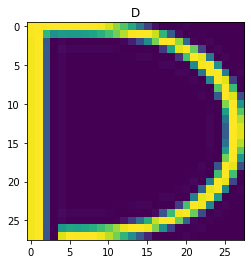

In [40]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

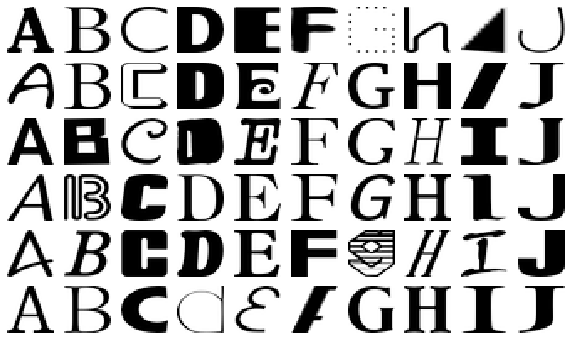

In [41]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [42]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [43]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
3. Dropout을 0.2 정도로 활용해볼 것 
-> later.Dropout()
->later.BatchNormalization()
4. 초기값은 default로
5. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
6. Early stopping도 활용해볼 것

In [44]:
from keras.utils import to_categorical

len_y = len(set(y_train)) # len(np.unique(y_train))
y_train = to_categorical(y_train, len_y)
y_test = to_categorical(y_test, len_y)

In [45]:
y_train.shape

(14979, 10)

In [ ]:
kera.backend.clear_session()

il = keras.layers.Input(shape=(28,28))


In [59]:
from tensorflow import keras

# 이전모델 클리어
keras.backend.clear_session()
# 모델 생성
model = keras.Sequential()
# 모델 블록 쌓기
model.add(keras.layers.Input(shape = (28,28,1)))
model.add(keras.layers.Flatten())


model.add(keras.layers.Dense(256, activation = 'relu'))
model.add(keras.layers.Dense(256, activation = 'relu'))
model.add(keras.layers.BatchNormalization()) # 성능을 좋게 하기 위한 테크닉 기법
model.add(keras.layers.Dropout(0.2)) # 성능을 좋게 하기 위한 테크닉 기법


model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.BatchNormalization()) # 성능을 좋게 하기 위한 테크닉 기법
model.add(keras.layers.Dropout(0.2)) # 성능을 좋게 하기 위한 테크닉 기법
model.add(keras.layers.Dense(10, activation = 'softmax'))

# 모델 컴파일
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],optimizer = 'adam')

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

In [60]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 5,
                   restore_best_weights = True)

In [61]:
model.fit(x_train, y_train, epochs = 50, callbacks=[es], validation_split=0.2,verbose = 1)

Epoch 1/50
375/375 [==============================] - 4s 5ms/step - loss: 0.5921 - accuracy: 0.8248 - val_loss: 0.5201 - val_accuracy: 0.8632
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 0.3971 - accuracy: 0.8839 - val_loss: 0.4859 - val_accuracy: 0.8692
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 0.3371 - accuracy: 0.8994 - val_loss: 0.4643 - val_accuracy: 0.8798
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.3069 - accuracy: 0.9100 - val_loss: 0.4104 - val_accuracy: 0.8812
Epoch 5/50
375/375 [==============================] - 2s 5ms/step - loss: 0.2800 - accuracy: 0.9173 - val_loss: 0.3613 - val_accuracy: 0.9005
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 0.2553 - accuracy: 0.9207 - val_loss: 0.3757 - val_accuracy: 0.8969
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 0.2348 - accuracy: 0.9298 - val_loss: 0.4048 - val_accuracy: 0.8925
Epoch 

In [53]:
y_pred = model.predict(x_test)

118/118 [==============================] - 0s 2ms/step


In [54]:
y_pred[:5]

array([[8.6538182e-07, 4.9102507e-08, 3.0555518e-07, 1.3603680e-05,
        2.8018190e-08, 3.3388351e-06, 8.1739422e-08, 1.0149205e-07,
        3.1978989e-04, 9.9966192e-01],
       [2.2493841e-05, 1.7021319e-08, 1.3077093e-07, 2.1236999e-06,
        2.1924114e-08, 5.5203383e-08, 1.1579073e-08, 9.9997377e-01,
        1.2394534e-06, 8.7324153e-08],
       [2.0777878e-05, 1.2259324e-03, 1.0014150e-05, 9.9718708e-01,
        1.6577391e-05, 7.5550624e-06, 1.7014250e-05, 9.9291377e-05,
        7.6870469e-04, 6.4711610e-04],
       [3.0471044e-06, 2.9756371e-05, 4.0483174e-05, 5.1677398e-05,
        1.7585786e-05, 9.9937266e-01, 2.7348162e-04, 7.9066291e-07,
        9.9294091e-05, 1.1117061e-04],
       [9.9235135e-01, 9.3856943e-04, 3.6724174e-05, 5.4676482e-04,
        1.2417826e-04, 3.2553853e-05, 1.2442049e-03, 4.0779728e-03,
        9.4445233e-05, 5.5328617e-04]], dtype=float32)

In [55]:
y_test [:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [64]:
## Functional API
# 1. 세션 클리어
keras.backend.clear_session()
# 2. 레이어 사슬처럼 엮기
il = keras.layers.Input(shape=(28,28,1))
fl = keras.layers.Flatten()(il)

hl1 = keras.layers.Dense(256, activation = 'relu')(fl)
hl2 = keras.layers.Dense(256, activation = 'relu')(hl1)
bl = keras.layers.BatchNormalization()(hl2)
dl = keras.layers.Dropout(0.2)(bl)

ol = keras.layers.Dense(10, activation = 'softmax')(dl)

# 3. 모델의 시작/끝 지정
model = keras.models.Model(il, ol)
# 4 컴파일
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
# 요약
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [65]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 5,
                   restore_best_weights = True)

In [66]:
model.fit(x_train, y_train, epochs = 50, callbacks=[es], validation_split=0.2,verbose = 1)

Epoch 1/50
375/375 [==============================] - 3s 4ms/step - loss: 0.4953 - accuracy: 0.8570 - val_loss: 0.4542 - val_accuracy: 0.8685
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.3427 - accuracy: 0.9008 - val_loss: 0.4302 - val_accuracy: 0.8872
Epoch 3/50
375/375 [==============================] - 1s 4ms/step - loss: 0.2987 - accuracy: 0.9120 - val_loss: 0.4318 - val_accuracy: 0.8792
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.2655 - accuracy: 0.9185 - val_loss: 0.4105 - val_accuracy: 0.8942
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.2251 - accuracy: 0.9323 - val_loss: 0.4170 - val_accuracy: 0.8872
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.2039 - accuracy: 0.9385 - val_loss: 0.4068 - val_accuracy: 0.8925
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1848 - accuracy: 0.9446 - val_loss: 0.3939 - val_accuracy: 0.8982
Epoch 

In [67]:
y_pred = model.predict(x_test)

118/118 [==============================] - 0s 1ms/step
